# Classification of genetic mutations based on clinical evidence provided as text description. <a class='tocSkip'>

**NOTICE: This is unfinished, active working copy**

Main approach will be first using NLP techniques to transform text description into features needed later for a few classifiers. Then choosing best working one.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# import gensim
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, log_loss
# from scikitplot.metrics import plot_confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


### Loading data <a class='tocSkip'>

In [ ]:
# Computed in Google Colab so GDrive was mounted as data source
from google.colab import drive
drive.mount('/content/gdrive')

In [4]:
train_text = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/training_text', sep='\|\|', header=None, skiprows=1, names=['ID','Text'], engine='python')
train_text.head(2)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...


In [5]:
train_variants = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/training_variants')
train_variants.head(2)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2


In [6]:
test_text = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/test_text', sep='\|\|', header=None, names=['ID','Text'], engine='python')
test_text.head(2)

,ID,Text
0,0,Oncogenic mutations in the monomeric Casitas B...
1,1,Abstract Background Non-small cell lung canc...


In [7]:
test_variants = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/test_variants', names=['ID','Gene','Variation','Class'])
test_variants.head(2)

,ID,Gene,Variation,Class
0,0,CBL,H398Q,4
1,1,CBL,S80N,6


**Joining dataframes**

In [8]:
df_train = pd.merge(train_variants, train_text, how='left', on='ID')
print(df_train.shape)
df_train.head()

(3321, 5)


,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
df_train.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
Text         object
dtype: object

In [10]:
df_test = pd.merge(test_variants, test_text, how='left', on='ID')
print(df_test.shape)
df_test.head()

(368, 5)


,ID,Gene,Variation,Class,Text
0,0,CBL,H398Q,4,Oncogenic mutations in the monomeric Casitas B...
1,1,CBL,S80N,6,Abstract Background Non-small cell lung canc...
2,2,SHOC2,M173I,4,Rasopathies are phenotypically similar syndrom...
3,3,DICER1,D1709N,4,Abstract DICER1 plays a critical role in mic...
4,4,PTPRT,S492F,1,The receptor protein tyrosine phosphatase T (P...


In [11]:
df_test.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
Text         object
dtype: object

### Basic information

In [12]:
# How the text description looks like 
df_train['Text'][0][:900]

'Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome'

In [13]:
df_train.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [14]:
df_test.describe(include='all')

,ID,Gene,Variation,Class,Text
count,368.000000,368,368,368.000000,367
unique,NaN,140,328,NaN,310
top,NaN,BRCA1,Truncating Mutations,NaN,Mutations in BRCA1 and BRCA2 account for the m...
freq,NaN,29,18,NaN,6
mean,183.500000,NaN,NaN,4.078804,NaN
std,106.376689,NaN,NaN,2.469826,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,91.750000,NaN,NaN,1.000000,NaN
50%,183.500000,NaN,NaN,4.000000,NaN
75%,275.250000,NaN,NaN,7.000000,NaN


**Checking class distribution**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


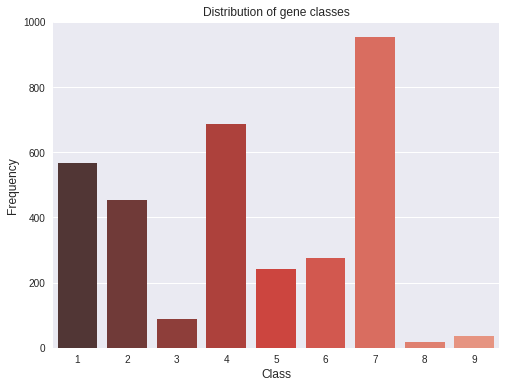

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(df_train['Class'], palette='Reds_d')
plt.title('Distribution of gene classes', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12);

Classes are imbalanced

In [0]:
# Let's check words distribution
df_train['Words_count'] = df_train['Text'].apply(lambda x: len(str(x).split(' ')))

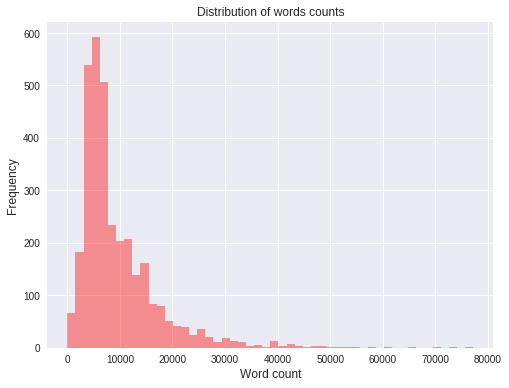

Median of words count is 6708.0


In [17]:
plt.figure(figsize=(8,6))
sns.distplot(df_train['Words_count'], color='red', kde=False)
plt.title('Distribution of words counts', fontsize=12)
plt.xlabel('Word count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

print('Median of words count is', df_train['Words_count'].median())

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


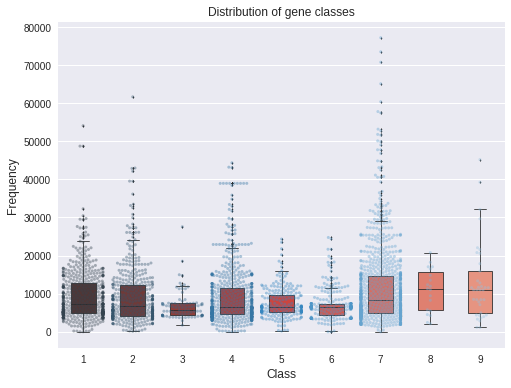

In [18]:
# Number of words in description by gene class
plt.figure(figsize=(8,6))
sns.swarmplot(x='Class', y='Words_count', data=df_train, palette='Blues_d', alpha=.4, size=3)
sns.boxplot(x='Class', y='Words_count', data=df_train, width=0.5, linewidth=0.8, fliersize=2, palette='Reds_d')
plt.title('Distribution of gene classes', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

Maybe we could also use this kind of dependency shown above to classify gene variants. It seems that the 3 & 6 variant is differently described.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


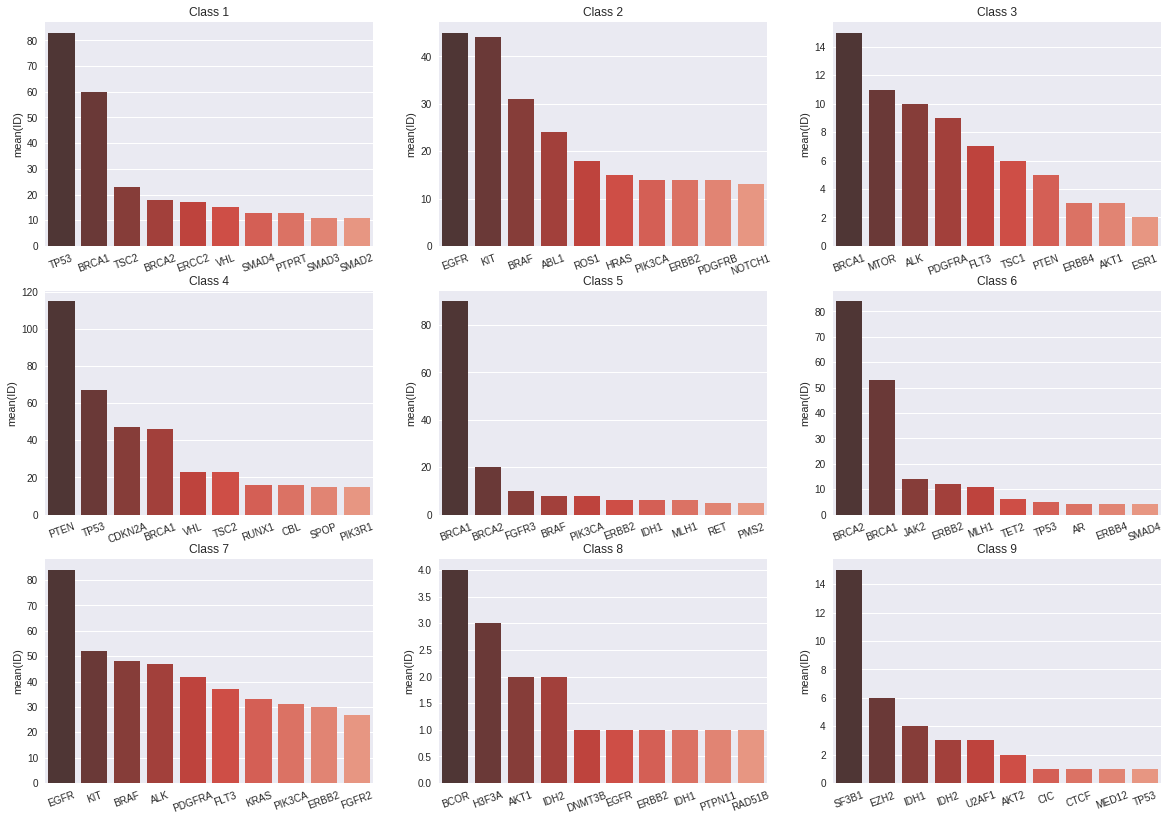

In [19]:
# Top10 genes in each class

fig, ax = plt.subplots(3, 3, figsize=(20,14))

n_id = 1
for i in range(3):
    for j in range(3):
        counts = df_train[df_train['Class'] == ((i*3+j)+1)].groupby('Gene')['ID'].count().reset_index()
        groups = counts.sort_values('ID', ascending=False)
        groups_top5 = groups[:10]
        g = sns.barplot(x='Gene', y='ID', data=groups_top5, palette='Reds_d',  ax=ax[i][j])
        ax[i][j].set_title('Class %s' % n_id)
        ax[i][j].set_xlabel(' ')
        plt.setp(g.get_xticklabels(), rotation=20, size=10)
        n_id += 1

In [20]:
# Statistics by class
df_train.groupby('Class')['Words_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,568.0,9481.813380,6546.450083,1.0,4970.00,7326.0,12725.25,54099.0
2,452.0,9356.723451,7657.874081,116.0,4176.75,6706.0,12336.25,61679.0
3,89.0,6765.842697,3701.478503,1755.0,4326.00,5625.0,7428.00,27572.0
4,686.0,9037.549563,7375.759126,53.0,4593.00,6375.0,11586.00,44358.0
5,242.0,7510.243802,3860.881987,183.0,5246.00,6514.0,9593.75,24343.0
6,275.0,7003.272727,3844.647905,1.0,4523.00,6620.0,7421.00,24757.0
7,953.0,11493.173137,10134.744568,1.0,4909.00,8322.0,14687.00,77202.0
8,19.0,10892.578947,5689.412080,2120.0,5632.00,11322.0,15652.00,20779.0
9,37.0,12875.351351,10249.082228,1153.0,4990.00,10986.0,15927.00,45215.0


In [21]:
# Looking at above minimal 'Word_count' equal 1, let's look at genes with missing values in description
df_train[df_train['Words_count'] == 1]

,ID,Gene,Variation,Class,Text,Words_count
1109,1109,FANCA,S1088F,1,NaN,1
1277,1277,ARID5B,Truncating Mutations,1,NaN,1
1407,1407,FGFR3,K508M,6,NaN,1
1639,1639,FLT1,Amplification,6,NaN,1
2755,2755,BRAF,G596C,7,NaN,1


## Baseline classification

In [0]:
# Helper function

def evaluate_features(X, y, clf=None):
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, 
                               cv=StratifiedKFold(random_state=42, n_splits=5), 
                               method='predict_proba',
                               n_jobs=-1)
    
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
#     plot_confusion_matrix(y, preds, cmap='Reds')

In [23]:
# Dropping variants without description 
df_train.dropna(subset=['Text'], inplace=True)
df_train.reset_index(drop=True)
df_train[df_train['Text'].isnull()]

,ID,Gene,Variation,Class,Text,Words_count


In [0]:
# Vectorizing free text into features
cv = TfidfVectorizer(
                    min_df=5, 
                    max_features=16000,
                    lowercase=True,
                    use_idf=True, 
                    smooth_idf=True, 
                    sublinear_tf=True,
                    strip_accents='unicode',
                    tokenizer=nltk.word_tokenize,
                    stop_words='english'
                    )    

In [25]:
# Needed by Google Colab
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
tfidf = cv.fit_transform(df_train['Text'])

In [27]:
# Corpus with 16k words as set in 'max_features' above
len(cv.get_feature_names())

16000

In [0]:
svd = TruncatedSVD(n_components=20, n_iter=20, random_state=42)
trunc_tfidf = svd.fit_transform(tfidf)

In [29]:
evaluate_features(trunc_tfidf, df_train['Class'].values,
                 SVC(kernel='linear', probability=True))

Log loss: 1.5197451935372077
Accuracy: 0.45386007237635706


Result not so promissing. Will try to improve it using LSTM approach.

### Top features by class

In [0]:
# Some more helper functions
def top_tfidf_feats(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 50))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        #z = int(str(int(i/3)+1) + str((i%3)+1))
        ax = fig.add_subplot(9, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=5, fontsize=12)
        ax.set_ylabel("Gene", labelpad=8, fontsize=14)
        ax.set_title("Class " + str(df.label), fontsize=14)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='maroon', alpha=.7)
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [0]:
y = df_train['Class']
features = cv.get_feature_names()
top_feat = top_feats_by_class(tfidf, y, features)

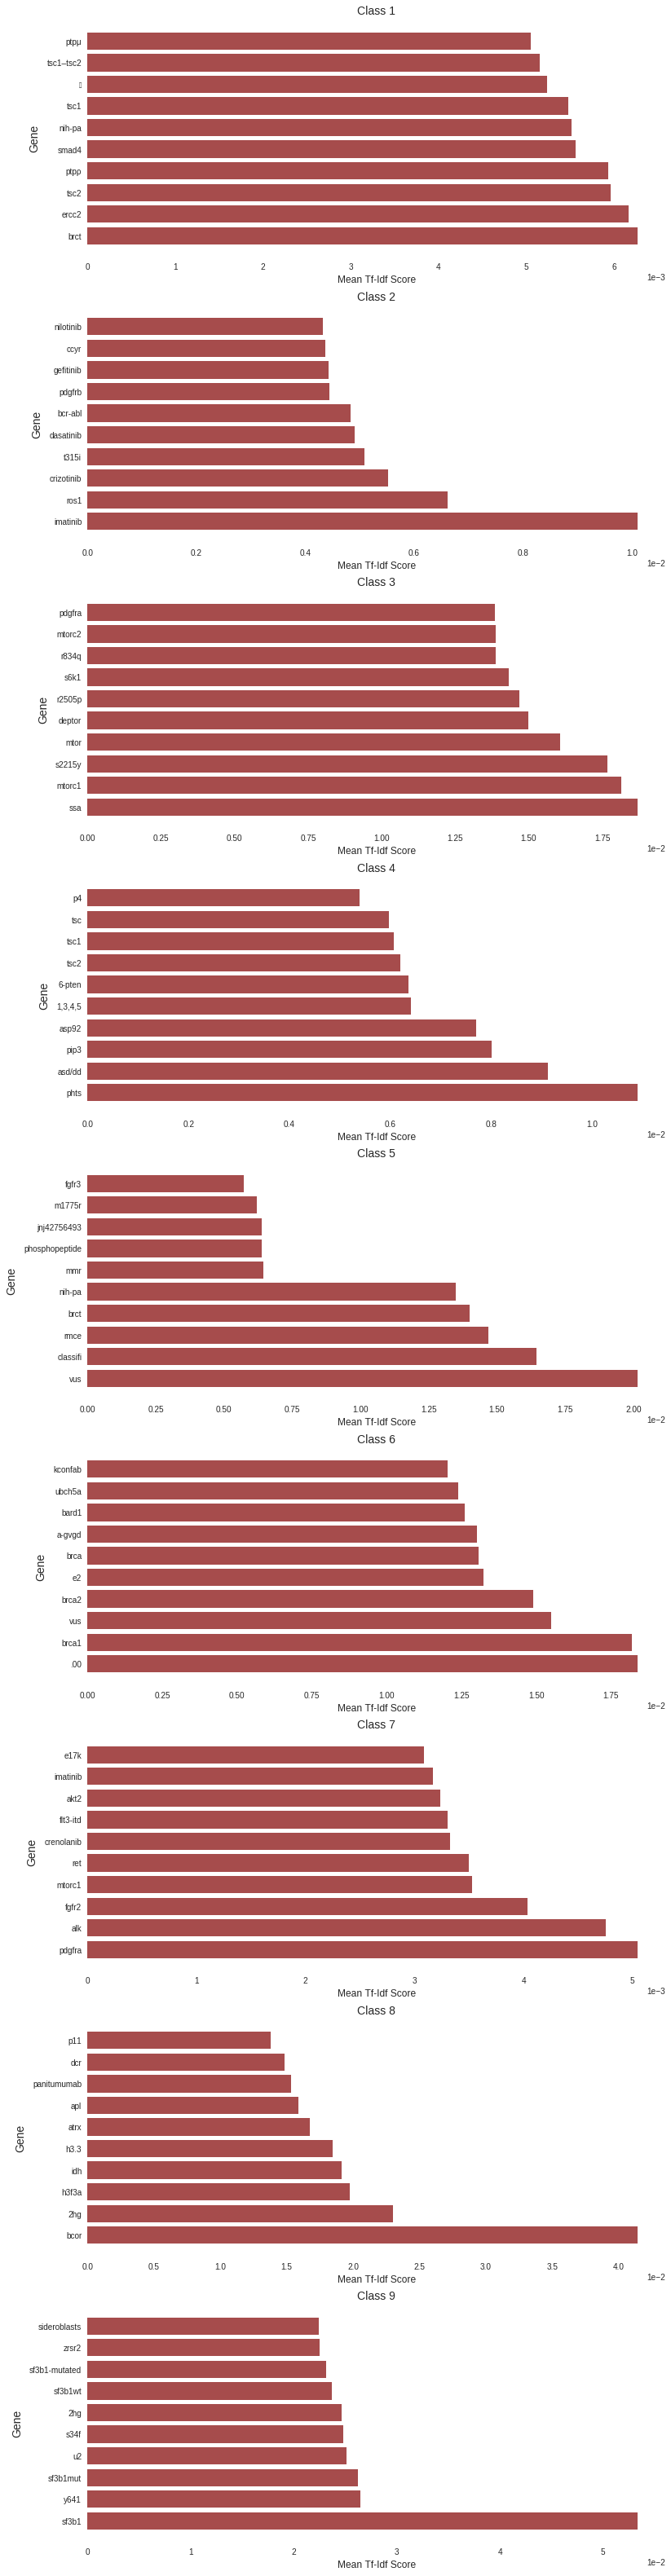

In [32]:
# Top features by class
plot_tfidf_classfeats_h(top_feat)

## Keras

**NOTICE: Due to long time to compute results run below code on GPU** 

In [0]:
# Tokenize
tokenizer = Tokenizer(num_words=2200)
tokenizer.fit_on_texts(df_train['Text'].values)

In [0]:
# Padding
X = tokenizer.texts_to_sequences(df_train['Text'].values)
X = pad_sequences(X, maxlen=2200)

In [36]:
# LSTM
num_words = 2200
embed_dim = 128
lstm_output = 196

# Model saving
mod_checkpoint = ModelCheckpoint('per_med_model', 
                                 monitor='val_loss',  
                                 save_best_only=True, 
                                 mode='auto',
                                 verbose=1)

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length=X.shape[1]))
model.add(LSTM(lstm_output, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['categorical_crossentropy'], optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2200, 128)         281600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 538,173
Trainable params: 538,173
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
y = pd.get_dummies(df_train['Class']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2652, 2200) (2652, 9)
(664, 2200) (664, 9)


In [38]:
model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.2, callbacks=[mod_checkpoint])

Train on 2121 samples, validate on 531 samples
Epoch 1/8
2121/2121 [==============================] - 450s 212ms/step - loss: 1.8757 - categorical_crossentropy: 1.8757 - val_loss: 1.8038 - val_categorical_crossentropy: 1.8038

Epoch 00001: val_loss improved from inf to 1.80381, saving model to per_med_model
Epoch 2/8
2121/2121 [==============================] - 455s 215ms/step - loss: 1.5313 - categorical_crossentropy: 1.5313 - val_loss: 1.4895 - val_categorical_crossentropy: 1.4895

Epoch 00002: val_loss improved from 1.80381 to 1.48948, saving model to per_med_model
Epoch 3/8
2121/2121 [==============================] - 459s 216ms/step - loss: 1.2043 - categorical_crossentropy: 1.2043 - val_loss: 1.3747 - val_categorical_crossentropy: 1.3747

Epoch 00003: val_loss improved from 1.48948 to 1.37472, saving model to per_med_model
Epoch 4/8
2121/2121 [==============================] - 459s 216ms/step - loss: 1.0180 - categorical_crossentropy: 1.0180 - val_loss: 1.3688 - val_categorical_c

In [0]:
model = load_model('per_med_model')

In [0]:
probas = model.predict(X_test)

In [41]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
print('accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds)))
# plot_confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)

log loss: 1.3557415083780078
accuracy: 0.5120481927710844


Result slighlty improved compared to TF-IDF approach.